###Cargar drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Librerias

In [ ]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 36.3 MB/s 


In [ ]:

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torchvision import transforms 
from torch import nn, optim
import torch.optim as optim
from torchvision.models import resnet101
import urllib.request
import cv2

from ignite.metrics import ClassificationReport
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

from genericpath import exists

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

##Clasificación multi-etiqueta

###DEA

In [ ]:
#data_base = pd.read_csv('/content/drive/MyDrive/Falabella/base1y2.csv')
#data_base = pd.read_excel('/content/drive/MyDrive/Falabella/data_revisada.xlsx')
data_base_train = pd.read_excel('/content/drive/MyDrive/Falabella/data_revisada_1/data_revisada_1_train.xlsx')
data_base_test = pd.read_excel('/content/drive/MyDrive/Falabella/data_revisada_1/data_revisada_1_test.xlsx')

In [ ]:
data_base_train = data_base_train.drop(columns = ['Unnamed: 0'])

In [ ]:
data_base_train

Unnamed: 0.1     id        Suborden  \
0                0      1      2130787479   
1                1      2      2130905477   
2                2      3      2130994563   
3                6      7      2131043277   
4                8      9      2131108907   
...            ...    ...             ...   
1667         16770  16882    149062202680   
1668         16771  16884    149062235273   
1669         16818  16932    149062226951   
1670         16832  16947    149061750502   
1671         16834  16949  14000119189601   

                                               Imageurl  Producto  \
0     https://firebasestorage.googleapis.com/v0/b/tx...         1   
1     https://firebasestorage.googleapis.com/v0/b/tx...         0   
2     https://firebasestorage.googleapis.com/v0/b/tx...         0   
3     https://firebasestorage.googleapis.com/v0/b/tx...         1   
4     https://firebasestorage.googleapis.com/v0/b/tx...         1   
...                                                 ...       ...   
1667  https://firebasestorage.googleapis.com/v0/b/tx...         0   
1668  https://firebasestorage.googleapis.com/v0/b/tx...         0   
1669  https://firebasestorage.googleapis.com/v0/b/tx...         0   
1670  https://firebasestorage.googleapis.com/v0/b/tx...         0   
1671  https://firebasestorage.googleapis.com/v0/b/tx...         0   

      Etiqueta Envio  Rostro cliente  Numeracion del Domicilio  
0                  0               0                         0  
1                  0               0                         0  
2                  0               0                         0  
3                  0               0                         0  
4                  0               0                         0  
...              ...             ...                       ...  
1667               0               0                         1  
1668               0               0                         1  
1669               0               0                         1  
1670               0               0                         1  
1671               0               0                         1  

[1672 rows x 8 columns]

In [ ]:
data_base_test = data_base_test.drop(columns = ['Unnamed: 0'])

In [ ]:
data_base_test 

Unnamed: 0.1     id      Suborden  \
0               0      1  149062365188   
1               6      7  149062051209   
2               7      8  149062388898   
3               8      9  149062408218   
4               9     10  149062526866   
..            ...    ...           ...   
413         16218  16282  149061826337   
414         16219  16283  149062258563   
415         16239  16304  149062692990   
416         16299  16366  149062267813   
417         16349  16418  149062306871   

                                              Imageurl  Producto  \
0    https://firebasestorage.googleapis.com/v0/b/tx...         1   
1    https://firebasestorage.googleapis.com/v0/b/tx...         1   
2    https://firebasestorage.googleapis.com/v0/b/tx...         1   
3    https://firebasestorage.googleapis.com/v0/b/tx...         1   
4    https://firebasestorage.googleapis.com/v0/b/tx...         1   
..                                                 ...       ...   
413  https://firebasestorage.googleapis.com/v0/b/tx...         0   
414  https://firebasestorage.googleapis.com/v0/b/tx...         0   
415  https://firebasestorage.googleapis.com/v0/b/tx...         0   
416  https://firebasestorage.googleapis.com/v0/b/tx...         0   
417  https://firebasestorage.googleapis.com/v0/b/tx...         0   

     Etiqueta Envio  Rostro cliente  Numeracion del Domicilio  
0                 1               0                         0  
1                 0               0                         0  
2                 1               0                         0  
3                 1               0                         0  
4                 1               0                         0  
..              ...             ...                       ...  
413               0               0                         1  
414               0               0                         1  
415               0               0                         1  
416               0               0                         1  
417               0               0                         1  

[418 rows x 8 columns]

In [ ]:
# identificación de clases 000, xx1, x1x, 1xx 
none_of_above_train = data_base_train[(data_base_train['Etiqueta Envio'] == 0) & (data_base_train['Numeracion del Domicilio'] == 0) & (data_base_train['Rostro cliente'] == 0)]
rostro_cliente_train = data_base_train[(data_base_train['Rostro cliente'] == 1)]
numeracion_domicilio_train = data_base_train[(data_base_train['Numeracion del Domicilio'] == 1)]
etiqueta_envio_train = data_base_train[(data_base_train['Etiqueta Envio'] == 1)]

print('none_of_above: ', len(none_of_above_train))
print('rostro_cliente: ', len(rostro_cliente_train))
print('numeracion_domicilio: ', len(numeracion_domicilio_train))
print('etiqueta_envio: ', len(etiqueta_envio_train))

none_of_above:  338
rostro_cliente:  586
numeracion_domicilio:  434
etiqueta_envio:  894


In [ ]:
# identificación de clases 000, xx1, x1x, 1xx 
none_of_above_test = data_base_test[(data_base_test['Etiqueta Envio'] == 0) & (data_base_test['Numeracion del Domicilio'] == 0) & (data_base_test['Rostro cliente'] == 0)]
rostro_cliente_test = data_base_test[(data_base_test['Rostro cliente'] == 1)]
numeracion_domicilio_test = data_base_test[(data_base_test['Numeracion del Domicilio'] == 1)]
etiqueta_envio_test = data_base_test[(data_base_test['Etiqueta Envio'] == 1)]

print('none_of_above: ', len(none_of_above_test))
print('rostro_cliente: ', len(rostro_cliente_test))
print('numeracion_domicilio: ', len(numeracion_domicilio_test))
print('etiqueta_envio: ', len(etiqueta_envio_test))

none_of_above:  85
rostro_cliente:  146
numeracion_domicilio:  108
etiqueta_envio:  223


In [ ]:
# identificación de clases 000, 001, 010, 011, 100, 101, 110, 111 
c_000_train = data_base_train[(data_base_train['Etiqueta Envio'] == 0) & (data_base_train['Numeracion del Domicilio'] == 0) & (data_base_train['Rostro cliente'] == 0)]
c_001_train = data_base_train[(data_base_train['Etiqueta Envio'] == 0) & (data_base_train['Numeracion del Domicilio'] == 0) & (data_base_train['Rostro cliente'] == 1)]
c_010_train = data_base_train[(data_base_train['Etiqueta Envio'] == 0) & (data_base_train['Numeracion del Domicilio'] == 1) & (data_base_train['Rostro cliente'] == 0)]
c_011_train = data_base_train[(data_base_train['Etiqueta Envio'] == 0) & (data_base_train['Numeracion del Domicilio'] == 1) & (data_base_train['Rostro cliente'] == 1)]
c_100_train = data_base_train[(data_base_train['Etiqueta Envio'] == 1) & (data_base_train['Numeracion del Domicilio'] == 0) & (data_base_train['Rostro cliente'] == 0)]
c_101_train = data_base_train[(data_base_train['Etiqueta Envio'] == 1) & (data_base_train['Numeracion del Domicilio'] == 0) & (data_base_train['Rostro cliente'] == 1)]
c_110_train = data_base_train[(data_base_train['Etiqueta Envio'] == 1) & (data_base_train['Numeracion del Domicilio'] == 1) & (data_base_train['Rostro cliente'] == 0)]
c_111_train = data_base_train[(data_base_train['Etiqueta Envio'] == 1) & (data_base_train['Numeracion del Domicilio'] == 1) & (data_base_train['Rostro cliente'] == 1)]
print('000: ', len(c_000_train))
print('001: ', len(c_001_train))
print('010: ', len(c_010_train))
print('011: ', len(c_011_train))
print('100: ', len(c_100_train))
print('101: ', len(c_101_train))
print('110: ', len(c_110_train))
print('111: ', len(c_111_train))

000:  338
001:  242
010:  158
011:  40
100:  380
101:  278
110:  210
111:  26


###Clase de datos

In [ ]:
t = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomRotation(20), 
                                                transforms.RandomAffine(degrees = 0, translate = (0.05,0.05)),
                                                 transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                        std=[0.229, 0.224, 0.225])])
t2 = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                    ])      

In [ ]:
# Dataset class 1

class PhotosLabelsDataset(Dataset):
    """Photos labels dataset."""

    def __init__(self, dataframe, root_dir, augmentation = True, normalize = True):
        """
        Args:
            xlsx_file (string): Path to the xlsx file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Boolean that indicates 
            a transformation or not.
        """
        #self.labels_frame = pd.read_excel(xlsx_file)
        self.labels_frame = dataframe
        self.root_dir = root_dir
        #self.transform = transform
        self.augmentation = augmentation
        #self.transformations = transforms.Compose([transforms.ToPILImage(),
        #                                           transforms.Resize((256, 256)),
        #                                           transforms.ToTensor()])

        self.transformations = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                        std=[0.229, 0.224, 0.225]),
                                                   ])
        
        self.augmentations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomRotation(20), 
                                                transforms.RandomAffine(degrees = 0, translate = (0.05,0.05)),
                                                 transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                        std=[0.229, 0.224, 0.225])])
        
        self.normalize = normalize

        self.transformations2 = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                    ])
        

        
        #self.none_of_above = data_base[(data_base['Etiqueta Envio'] == 0) & (data_base['Numeracion del Domicilio'] == 0) & (data_base['Rostro cliente'] == 0)]
        #self.rostro_cliente = data_base[(data_base['Etiqueta Envio'] == 0) & (data_base['Numeracion del Domicilio'] == 0) & (data_base['Rostro cliente'] == 1)]
        #self.numeracion_domicilio = data_base[(data_base['Etiqueta Envio'] == 0) & (data_base['Numeracion del Domicilio'] == 1) & (data_base['Rostro cliente'] == 0)]
        #self.etiqueta_envio = data_base[(data_base['Etiqueta Envio'] == 1) & (data_base['Numeracion del Domicilio'] == 0) & (data_base['Rostro cliente'] == 0)]
        
        
    #def lenclasses(self):
    #    len_c0 = len(self.none_of_above)
    #    len_c1 = len(self.rostro_cliente)
    #    len_c2 = len(self.numeracion_domicilio)
    #    len_c3 = len(self.etiqueta_envio)
    #    return [len_c0, len_c1, len_c2, len_c3]

        #self.target_c_001 = np.array([0,0,1], dtype = float)
    
    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        base = self.labels_frame
        img_name = str(base.iloc[idx, 1]) + '_' + str(base.iloc[idx, 2]) + '.png'
        #print(img_name)
        full_img_name = os.path.join(self.root_dir, img_name) 
        image =io.imread(full_img_name)
        #print(image.shape)
        if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        #producto = base.iloc[idx]['Producto']
        etiqueta = base.iloc[idx]['Etiqueta Envio']
        num_domicilio = base.iloc[idx]['Numeracion del Domicilio']
        rostro = base.iloc[idx]['Rostro cliente']

        #label = np.array([producto, etiqueta, num_domicilio, rostro], dtype = float)
        label = np.array([etiqueta, num_domicilio, rostro], dtype = float)

        sample = {'image': image, 'label': label}

        if self.augmentation:
            #print('t1')
            #if (label == self.target_c_001).all():
            #    sample['image'] = self.augmentations(sample['image']) 
            #else:
            #    sample['image'] = self.transformations(sample['image'])
            sample['image'] = self.augmentations(sample['image'])
            #print('t1 fin')

        #if self.transform:
        elif self.normalize:
            #print('t2')
            sample['image'] = self.transformations(sample['image'])
            #print('t2 fin')
        
        else:
          #print('t3')
          sample['image'] = self.transformations2(sample['image'])
          #print('t3 fin')

        return sample

In [ ]:
path_dir = '/content/drive/MyDrive/Falabella/data_revisada_1/train'
train_set = PhotosLabelsDataset(dataframe = data_base_train, 
                              root_dir = path_dir,
                              augmentation = True)
trainloader = DataLoader(train_set, batch_size=32, num_workers=2,
                         shuffle = True)

In [ ]:
path_dir = '/content/drive/MyDrive/Falabella/data_revisada_1/test'
test_set = PhotosLabelsDataset(dataframe = data_base_test, 
                              root_dir = path_dir,
                              augmentation = False)

testloader = DataLoader(test_set, batch_size=32, num_workers=2,
                         shuffle = True)

###Modelo

In [ ]:
# Cargar backbone

device='cuda'

class MultilabelClassifier(nn.Module):
    def __init__(self, n_classes, pretrain_model):
        super().__init__()
        self.pretrain_model = pretrain_model
        self.model_wo_fc = nn.Sequential(*(list(self.pretrain_model.children())[:-1]))

        self.classes = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=2048, out_features=3)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.model_wo_fc(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)

        return {
            'label': self.classes(x)
        }



###Define a Loss function, optimizer and model

In [ ]:
from torchvision.models import resnext101_32x8d
resnext = resnext101_32x8d(pretrained=True)

In [ ]:
from torchvision.models import resnet101
device='cuda'
#resnet = resnet101(pretrained=True)
net = MultilabelClassifier(3, resnext).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###Train the network

In [ ]:
# Entrenamiento

num_epochs = 100
PATH = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'
# perdida de validación antes de cada epoca
val_loss_ini = 1000
# limite de epocas en que aumenta la pérdida de validación
epochs_limit = 5
# numero de epocas en que aumenta la perdida de validación y 
# hay que terminar el entrenamiento
epochs = 0
# listas vacias para almacenar perdidas
train_losses = []
val_losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoca actual: ', epoch)
    epocas = epoch

    running_loss = 0.0

    train_loss = 0
    val_loss = 0
    
    #for i, data in enumerate(trainloader, 0):
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs = data['image'].to(device)
        labels = data['label'].to(device)
        #print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs)
        #print(outputs['label'].shape)
        loss = criterion(outputs['label'], labels).to(device)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_loss += loss.item()


        #print(running_loss)
        if i % 10 == 9:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
            #count = 0
    
    train_losses.append(train_loss/len(trainloader))

    # validación
    for i, data in enumerate(testloader):
      with torch.no_grad():
        net.eval()
        for images, targets in testloader:
          #count+=1

          val_inputs = data['image'].to(device)
          val_labels = data['label'].to(device)
          
          val_outputs = net(val_inputs)

          val_loss += criterion(val_outputs['label'], val_labels).to(device).item()

    val_loss = val_loss/len(testloader)

    val_losses.append(val_loss)  
    print('val_loss :', val_loss)

    # early stopping
    if val_loss <= val_loss_ini:
      # se guarda el modelo
      torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'validation loss': val_loss,
            }, PATH)
      # se actualiza validation_loss
      val_loss_ini = val_loss
      # se actualizan epocas
      epochs = 0
    
    elif val_loss > val_loss_ini and epochs < epochs_limit:
      # se termina entrenamiento
      epochs += 1

    else:
      # se termina entrenamiento
      break

print('Finished Training')

epoca actual:  0
[1,    10] loss: 0.681
[1,    20] loss: 0.630
[1,    30] loss: 0.592
[1,    40] loss: 0.553
[1,    50] loss: 0.522
val_loss : 7.2767183868854906
epoca actual:  1
[2,    10] loss: 0.430
[2,    20] loss: 0.352
[2,    30] loss: 0.280
[2,    40] loss: 0.269
[2,    50] loss: 0.255
val_loss : 3.358775581925189
epoca actual:  2
[3,    10] loss: 0.211
[3,    20] loss: 0.196
[3,    30] loss: 0.153
[3,    40] loss: 0.186
[3,    50] loss: 0.159
val_loss : 2.7852120800161444
epoca actual:  3
[4,    10] loss: 0.129
[4,    20] loss: 0.143
[4,    30] loss: 0.123
[4,    40] loss: 0.165
[4,    50] loss: 0.102
val_loss : 3.359644353596054
epoca actual:  4
[5,    10] loss: 0.091
[5,    20] loss: 0.080
[5,    30] loss: 0.115
[5,    40] loss: 0.123
[5,    50] loss: 0.112
val_loss : 3.4120717393639928
epoca actual:  5
[6,    10] loss: 0.072
[6,    20] loss: 0.077
[6,    30] loss: 0.096
[6,    40] loss: 0.080
[6,    50] loss: 0.110
val_loss : 2.2879772299097683
epoca actual:  6
[7,    10] lo

ValueError: ignored

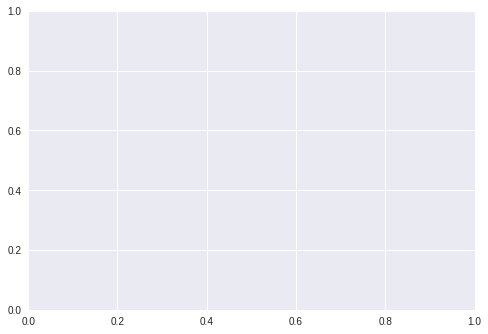

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# training and validation loss
mpl.style.use('seaborn')
plt.plot(epocas, train_losses, 'teal', label='Training loss')
plt.plot(epocas, val_losses, 'orange', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Cargar modelo

In [ ]:
# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

In [ ]:
from torchvision.models import resnext101_32x8d
resnext = resnext101_32x8d(pretrained=True)
PATH = '/content/drive/MyDrive/Falabella/mlc_model_baseline_data_revisada_1_2.pth'
model = MultilabelClassifier(3, resnext).to(device)
model_dict = torch.load(PATH)
model.load_state_dict(model_dict['model_state_dict'])
model.eval()

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

MultilabelClassifier(
  (pretrain_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [ ]:
model_dict

{'epoch': 10,
 'model_state_dict': OrderedDict([('pretrain_model.conv1.weight',
               tensor([[[[-1.3998e-03,  1.7548e-02,  1.0757e-02,  ..., -4.1117e-02,
                          -8.0906e-03,  4.1000e-04],
                         [-2.2855e-02, -5.8230e-02, -2.1707e-02,  ...,  1.4311e-01,
                           4.6037e-02, -1.4306e-02],
                         [ 1.6444e-02,  1.7885e-02, -9.3962e-02,  ..., -3.9129e-01,
                          -1.8075e-01, -4.0462e-03],
                         ...,
                         [-1.7523e-02, -3.9567e-02, -1.7503e-01,  ..., -1.6338e-01,
                           4.3315e-02,  8.8484e-02],
                         [-2.6617e-02, -5.2663e-02, -1.5750e-02,  ..., -1.5142e-01,
                          -2.0967e-01, -1.2616e-01],
                         [ 1.7649e-02,  3.4440e-02,  2.7921e-02,  ...,  1.0424e-01,
                           8.4244e-02,  3.4084e-02]],
               
                        [[ 1.3419e-02,  1.4392e-02,

###Evaluar modelo

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
y_pred = torch.empty(0).to(device)
y_true = torch.empty(0).to(device)
classes = ['etiqueta envio','numeracion del domicilio','rostro cliente']
with torch.no_grad():
    for data in testloader:
        print(data['image'].shape)
        inputs = data['image'].to(device)
        labels = data['label'].to(device)
        #print(data)
        #print(labels.shape)
        #print(y_true.shape)
        y_true = torch.cat((y_true.double(), labels.double()), 0)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        #print(outputs['label'].shape)
        # the class with the highest energy is what we choose as prediction
        #_, predicted = torch.max(outputs['label'].data, 1)
        #print(predicted)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
      #concatenación de tensores
        #print(outputs['label'])
        y_pred = torch.cat((y_pred, outputs['label']), 0)
        #print(y_pred.shape)
    print(y_pred.shape)
    print(y_true.shape)
    #print(y_pred)
    y_pred_sig = torch.sigmoid(y_pred)
    print(y_pred_sig.shape)
    y_pred = y_pred_sig.round().unsqueeze(0)
    y_true = y_true.unsqueeze(0)
    metric = ClassificationReport(output_dict=True, is_multilabel=True, labels = classes)
    metric.attach(default_evaluator, "cr")
    state = default_evaluator.run([[y_pred, y_true]])
    print(state)
#print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([2, 3, 224, 224])
torch.Size([418, 3])
torch.Size([418, 3])
torch.Size([418, 3])
State:
	iteration: 1
	epoch: 1
	epoch_length: 1
	max_epochs: 1
	output: <class 'list'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'list'>
	seed: <class 'NoneType'>
	times: <class 'dict'>



In [ ]:
print(state.metrics["cr"]["etiqueta envio"])
print(state.metrics["cr"]["numeracion del domicilio"])
print(state.metrics["cr"]["rostro cliente"])
print(state.metrics["cr"]["macro avg"])

{'precision': 0.9746192893401016, 'recall': 0.8609865470852018, 'f1-score': 0.9142857142857138}
{'precision': 0.9634146341463414, 'recall': 0.7314814814814815, 'f1-score': 0.8315789473684205}
{'precision': 0.9586206896551724, 'recall': 0.952054794520548, 'f1-score': 0.9553264604810991}
{'precision': 0.9655515377138718, 'recall': 0.8481742743624104, 'f1-score': 0.9003970407117444}


In [ ]:
# matriz de confusion

In [ ]:
path_dir = '/content/drive/MyDrive/Falabella/data_revisada'
test_set = PhotosLabelsDataset(dataframe = test, 
                              root_dir = path_dir,
                              augmentation = False, normalize = True)

testloader = DataLoader(test_set, batch_size=32, num_workers=2,
                         shuffle = True)

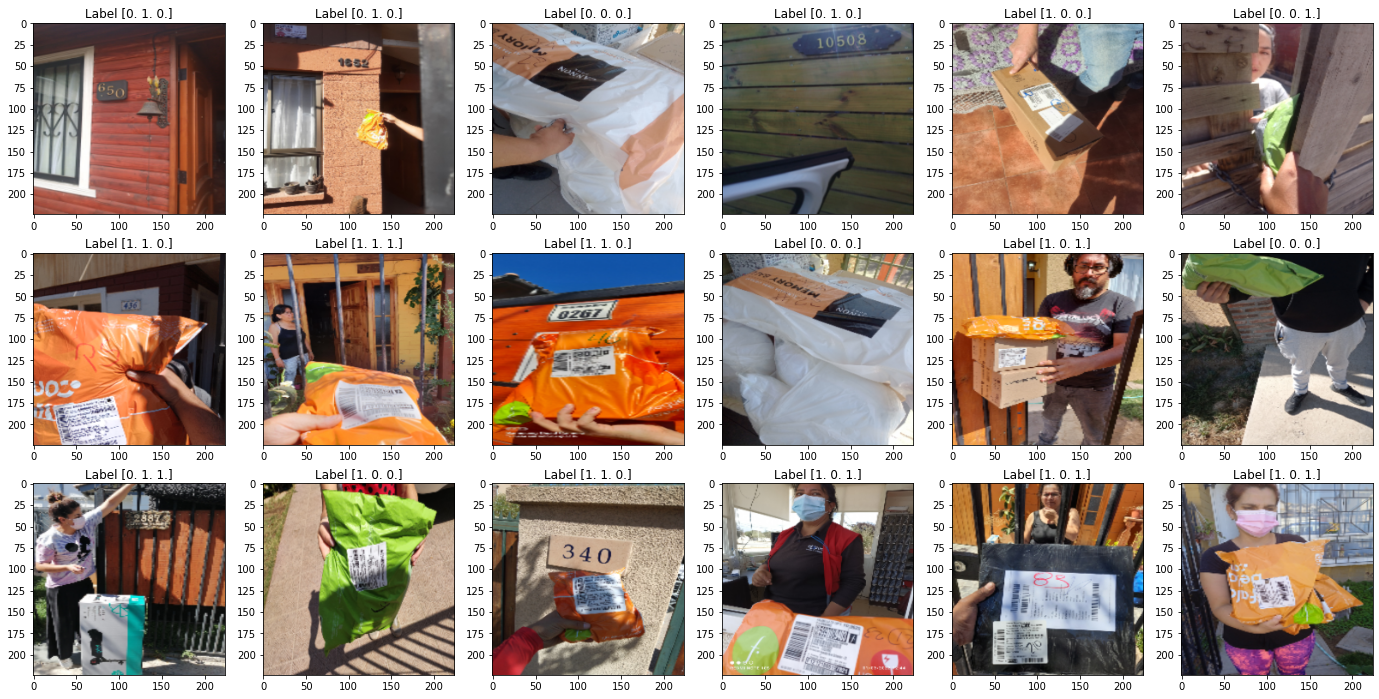

In [ ]:
# Visualización de algunas imagenes 
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
for i in range(h):
  for j in range(w):
    img = test_set[idx]['image']
    label = test_set[idx]['label']
    idx += 1
    axs[i,j].set_title('Label {}'.format(label))
    axs[i,j].imshow(img.permute(1,2,0))

In [ ]:
inputs = data['image'].to(device)

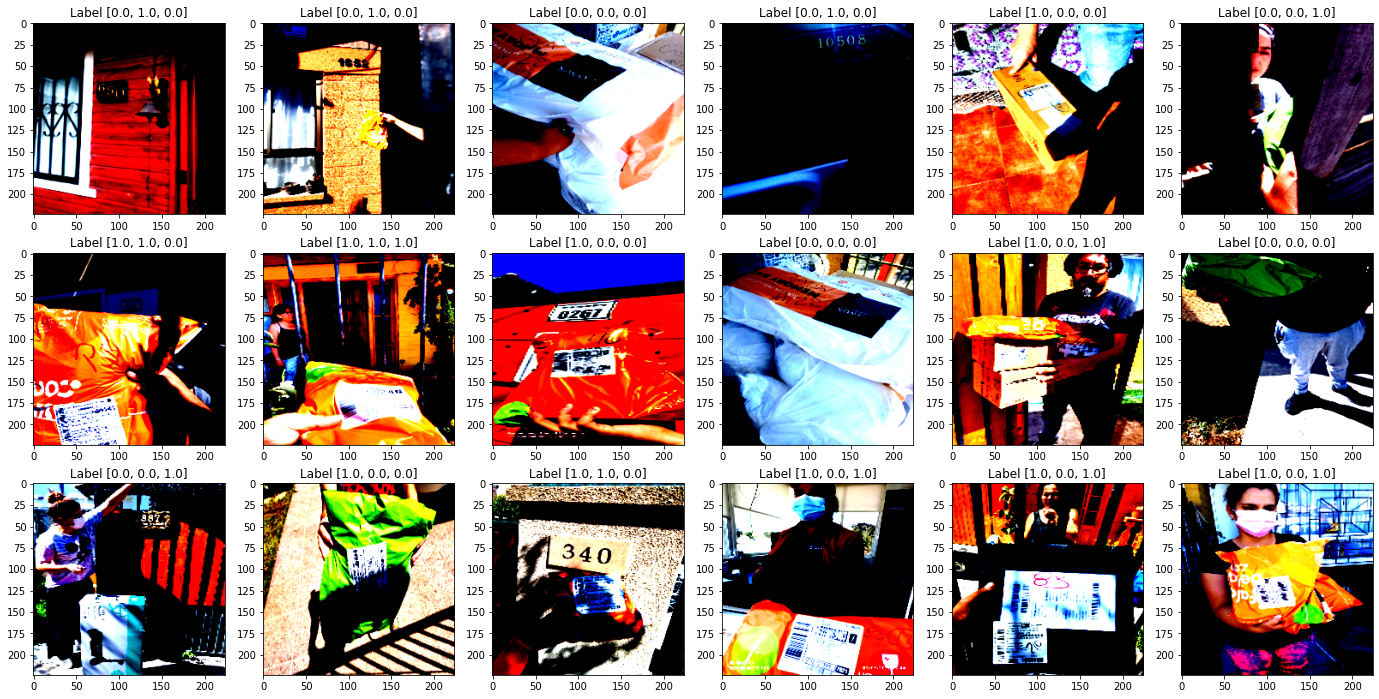

In [ ]:
# Visualización de predicciones
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  for i in range(h):
    for j in range(w):
      img_base = test_set[idx]['image']
      img = img_base.unsqueeze(dim = 0)
      label_base = model(img.to(device))
      label = torch.sigmoid(label_base['label']).round()
      idx += 1
      axs[i,j].set_title('Label {}'.format(label[0].tolist()))
      axs[i,j].imshow(img_base.permute(1,2,0))

In [ ]:
# función para calcular accuracy 1:1
import os
from skimage import io, transform
import matplotlib.pyplot as plt


def od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda'):
  mal_etiqueta = 0
  mal_domicilio = 0
  mal_rostro = 0
  acc = 0
  df = pd.read_excel(path_xlsx)
  model.to(device)
  model.eval()              # turn the model to evaluate mode
  count = 0
  acc_etiqueta = 0
  acc_numeracion = 0
  acc_rostro = 0
  y_true = []
  y_pred = []
  y_score = []
  transformations = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                        std=[0.229, 0.224, 0.225]),
                                                   ])
  with torch.no_grad():
    for img_name in os.listdir(path_images):
      full_img_name = os.path.join(path_images, img_name)
      image =io.imread(full_img_name)
      t_img = transformations(image)
      #plt.imshow(t_img.permute(1,2,0))
      #plt.show()
      img = t_img.unsqueeze(dim = 0)
      label_base = model(img.to(device))
      score = torch.sigmoid(label_base['label'])
      label = score.round()
      #print(label_base)
      #print(score)
      #print(label)
      #t_img = transform.resize(image, (480, 480))
      #t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
      prediction = label[0].tolist()
      indice = int(img_name.split('.')[0])
      etiqueta_envio = df.loc[indice]['Etiqueta producto']
      numeracion = df.loc[indice]['Numero domicilio']
      rostro_cliente = df.loc[indice]['Aparece Rostro']
      true_class = [etiqueta_envio, numeracion, rostro_cliente]
      y_true.append(true_class)
      y_pred.append(prediction)
      y_score.append(score[0].tolist())
      #print(img_name.split('.')[0])
      #print(prediction)
      #print(true_class)
      #print('')
      diferencia = np.array(true_class) - np.array(prediction)
      if diferencia[0] == 0:
        acc_etiqueta += 1
      if diferencia[1] == 0:
        acc_numeracion += 1
      if diferencia[2] == 0:
        acc_rostro += 1
      #if diferencia[0] != 0 and mal_etiqueta < 50:
        # mostrar imagen
        #plt.imshow(image)
        #plt.show()
        # mostrar true_class y prediction
        #print('true class: ', true_class)
        #print('prediction: ', prediction) 
        #mal_etiqueta += 1  
      #if diferencia[1] != 0 and mal_domicilio < 50:
        # mostrar imagen
        #plt.imshow(image)
        #plt.show()
        # mostrar true_class y prediction
        #print('true class: ', true_class)
        #print('prediction: ', prediction)   
        #mal_domicilio += 1
      #if diferencia[0] != 0 and mal_rostro < 50:
        # mostrar imagen
        #plt.imshow(image)
        #plt.show()
        # mostrar true_class y prediction
        #print('true class: ', true_class)
        #print('prediction: ', prediction)  
        #mal_rostro += 1 

      count+=1
    acc_etiqueta = acc_etiqueta/count
    acc_numeracion = acc_numeracion/count
    acc_rostro = acc_rostro/count

    return acc_etiqueta, acc_numeracion, acc_rostro, y_true, y_pred, y_score

In [ ]:
path_images = '/content/drive/MyDrive/Falabella/test_1000_imagenes/imagenes'
path_xlsx = '/content/drive/MyDrive/Falabella/test_1000_imagenes/etiquetado ML.xlsx'
acc_etiqueta, acc_numeracion, acc_rostro, y_true, y_pred, y_score= od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda')

In [ ]:
true_etiqueta = [true_value[0] for true_value in y_true]
true_numeracion = [true_value[1] for true_value in y_true] 
true_rostro = [true_rostro[2] for true_rostro in y_true]

In [ ]:
score_etiqueta = [score_value[0] for score_value in y_score]
score_numeracion = [score_value[1] for score_value in y_score] 
score_rostro = [score_rostro[2] for score_rostro in y_score]

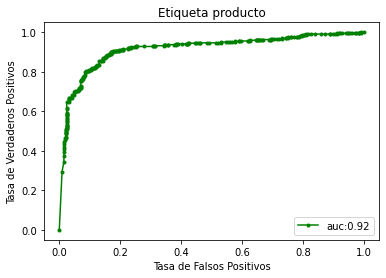

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calculamos la curva ROC para etiqueta
fpr, tpr, _ = roc_curve(true_etiqueta , score_etiqueta)
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_etiqueta, score_etiqueta)
label = 'auc:' + str(round(auc,2))
plt.plot(fpr, tpr, marker='.', label = label, color = 'green')
# Etiquetas de los ejes
plt.title('Etiqueta producto')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
plt.show()

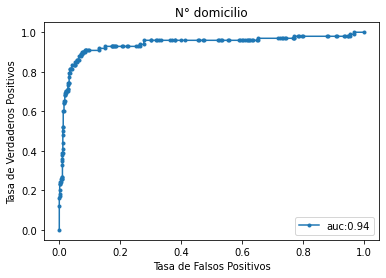

In [ ]:
from sklearn.metrics import roc_curve
# Calculamos la curva ROC para etiqueta
fpr, tpr, _ = roc_curve(true_numeracion , score_numeracion)
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_numeracion, score_numeracion)
label = 'auc:' + str(round(auc,2))
plt.plot(fpr, tpr, marker='.', label = label)
# Etiquetas de los ejes
plt.title('N° domicilio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
plt.show()

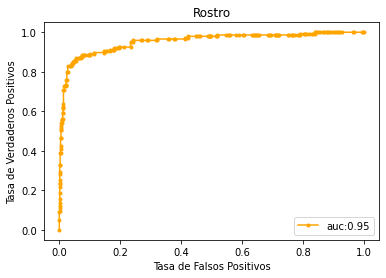

In [ ]:
from sklearn.metrics import roc_curve
# Calculamos la curva ROC para etiqueta
fpr, tpr, _ = roc_curve(true_rostro , score_rostro)
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_rostro, score_rostro)
label = 'auc:' + str(round(auc,2))
plt.plot(fpr, tpr, marker='.', label = label, color = 'orange')
# Etiquetas de los ejes
plt.title('Rostro')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
plt.show()

In [ ]:
print('acc_etiqueta: ', acc_etiqueta)
print('acc_numeracion: ', acc_numeracion)
print('acc_rostro: ', acc_rostro)

acc_etiqueta:  0.8612385321100917
acc_numeracion:  0.8967889908256881
acc_rostro:  0.9369266055045872


Matriz de confusión y métricas para etiqueta etiqueta:
[[283  47]
 [ 74 468]]
accuracy: 0.8612385321100917 recall: 0.8634686346863468 precision: 0.9087378640776699 F1: 0.8855250709555345


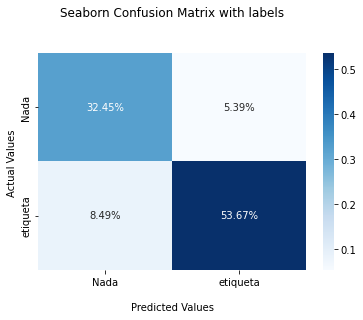

Matriz de confusión y métricas para etiqueta numeración:
[[693  81]
 [  9  89]]
accuracy: 0.8967889908256881 recall: 0.9081632653061225 precision: 0.5235294117647059 F1: 0.664179104477612


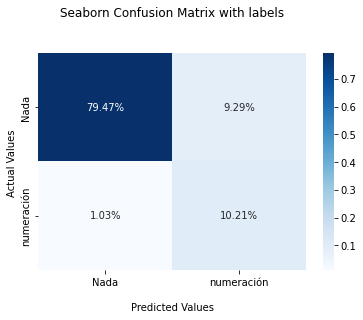

Matriz de confusión y métricas para etiqueta rostro:
[[694  32]
 [ 23 123]]
accuracy: 0.9369266055045872 recall: 0.8424657534246576 precision: 0.7935483870967742 F1: 0.8172757475083057


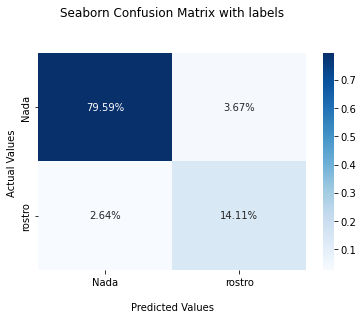

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.array(y_true)
y_pred = np.array(y_pred)

labels = ["etiqueta", "numeración", "rostro"]

conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Matriz de confusión y métricas para etiqueta {}:".format(label))
    print(matrix)
    accuracy = (matrix[0][0]+matrix[1][1])/(matrix[0][0] + matrix[0][1] + matrix[1][0]+matrix[1][1])
    recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])
    precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
    F1 = 2*recall*precision/(recall + precision)
    print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)
    ax = sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Nada', label])
    ax.yaxis.set_ticklabels(['Nada', label])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

Matriz de confusión y métricas para etiqueta etiqueta:
[[297  33]
 [101 441]]
accuracy: 0.8463302752293578 recall: 0.8136531365313653 precision: 0.930379746835443 F1: 0.8681102362204723


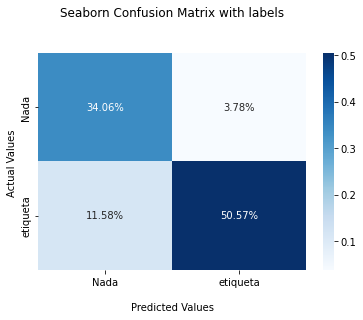

Matriz de confusión y métricas para etiqueta numeración:
[[730  44]
 [ 16  82]]
accuracy: 0.9311926605504587 recall: 0.8367346938775511 precision: 0.6507936507936508 F1: 0.7321428571428571


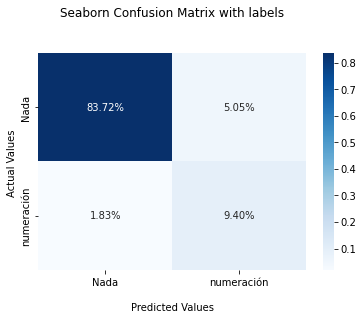

Matriz de confusión y métricas para etiqueta rostro:
[[716  10]
 [ 32 114]]
accuracy: 0.9518348623853211 recall: 0.7808219178082192 precision: 0.9193548387096774 F1: 0.8444444444444444


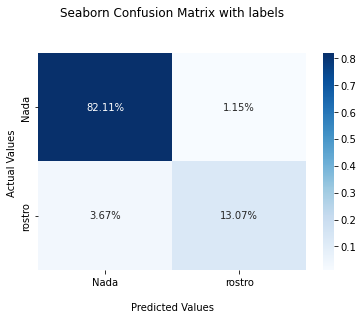

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.array(y_true)
y_pred = np.array(y_pred)

labels = ["etiqueta", "numeración", "rostro"]

conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Matriz de confusión y métricas para etiqueta {}:".format(label))
    print(matrix)
    accuracy = (matrix[0][0]+matrix[1][1])/(matrix[0][0] + matrix[0][1] + matrix[1][0]+matrix[1][1])
    recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])
    precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
    F1 = 2*recall*precision/(recall + precision)
    print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)
    ax = sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Nada', label])
    ax.yaxis.set_ticklabels(['Nada', label])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

Confusion matrix for label A:
[[1 1]
 [0 1]]


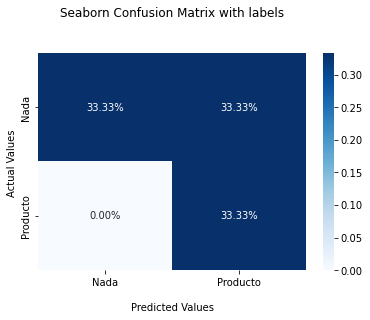

Confusion matrix for label B:
[[1 0]
 [2 0]]


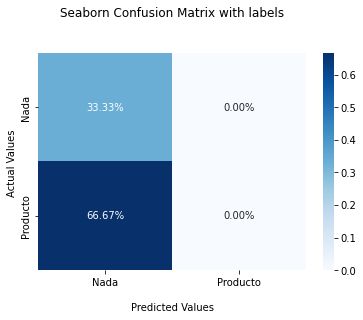

Confusion matrix for label c:
[[1 1]
 [0 1]]


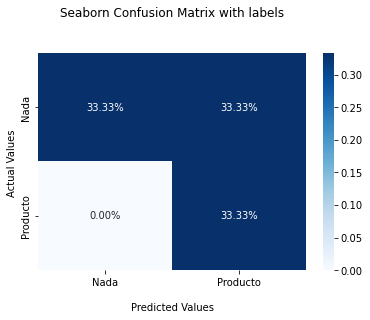

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_true = np.array([[0,0,1], [1,1,0],[0,1,0]])
y_pred = np.array([[0,0,1], [1,0,1],[1,0,0]])


labels = ["A", "B", "c"]

conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)
    ax = sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Nada','Producto'])
    ax.yaxis.set_ticklabels(['Nada','Producto'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
device = 'cuda'
model.to(device)
model.eval()        


transformations = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.Resize((224, 224)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                        std=[0.229, 0.224, 0.225]),
                                                   ])
with torch.no_grad():
    for img_name in os.listdir(path_images):
      full_img_name = os.path.join(path_images, img_name)
      image =io.imread(full_img_name)
      t_img = transformations(image)
      img = t_img.unsqueeze(dim = 0)
      label_base = model(img.to(device))
      label = torch.sigmoid(label_base['label']).round()
      #t_img = transform.resize(image, (480, 480))
      #t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
      prediction = label[0].tolist()
      idx += 1
      axs[i,j].set_title('Label {}'.format(label[0].tolist()))
      axs[i,j].imshow(img_base.permute(1,2,0))

In [ ]:
# Visualización de predicciones
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  for i in range(h):
    for j in range(w):
      img_base = test_set[idx]['image']
      img = img_base.unsqueeze(dim = 0)
      label_base = model(img.to(device))
      label = torch.sigmoid(label_base['label']).round()
      idx += 1
      axs[i,j].set_title('Label {}'.format(label[0].tolist()))
      axs[i,j].imshow(img_base.permute(1,2,0))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
y_test = np.array(y_test_list)
y_pred = np.array(y_pred_list)
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nada','Producto'])
ax.yaxis.set_ticklabels(['Nada','Producto'])

## Display the visualization of the Confusion Matrix.
plt.show()